In [2]:
import gc
import os
import sys
import torch
import random

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.nn import L1Loss
from monai.inferers import sliding_window_inference

from monai.data import DataLoader, Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    EnsureChannelFirstd,
    CenterSpatialCropd,
    RandAxisFlipd,
    RandRotate90d,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandGaussianSharpend,
)

from model.iterUNet import Baseline_IUnet
from dataset.custom_transforms import RandCropByPosNegLabeld_Custom
from loss.combined_loss import compute_total_loss

import warnings
warnings.filterwarnings("ignore", message=".*unable to generate class balanced samples.*")

In [3]:
project_name = 'warmup_training'

dir_path = f'./{project_name}'
subdir_li = ['models', 'valid_images', 'loss_trends']

if os.path.exists(dir_path) == False :
    os.mkdir(dir_path)
    
for name in subdir_li:
    subdir_path = f'{dir_path}/{name}'
    if os.path.exists(subdir_path) == False :
        os.mkdir(subdir_path)

In [5]:
data_path = 'data_path'
# data/
# ├── case001/
# │   ├── pre.nii.gz     #pre contrast
# │   ├── 1dyn.nii.gz
# │   ├── 2dyn.nii.gz
# │   ├── 3dyn.nii.gz
# │   ├── 4dyn.nii.gz
# │   ├── 5dyn.nii.gz
# │   ├── seg.nii.gz     # cancer region segmentation
# │   └── roi.nii.gz     # breast tissue region segmentation
# ├── case002/
# │   ├── pre.nii.gz
# │   ├── 1dyn.nii.gz
# │   └── 2dyn.nii.gz
# └── ...

In [8]:
fd = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

random.seed(42)
tr_size = 144
vd_size =16
vd_list = random.sample(fd, vd_size)
tr_list = [item for item in fd if item not in vd_list]

In [9]:
plist_tr = [
    {
        "img_pre" : os.path.join(data_path,n,"pre.nii.gz"),    #pre contrast
        "img_1dyn": os.path.join(data_path,n,"1dyn.nii.gz"),
        "img_2dyn": os.path.join(data_path,n,"2dyn.nii.gz"),
        "img_3dyn": os.path.join(data_path,n,"3dyn.nii.gz"),
        "img_4dyn": os.path.join(data_path,n,"4dyn.nii.gz"),
        "img_5dyn": os.path.join(data_path,n,"5dyn.nii.gz"),
        "seg" : os.path.join(data_path,n,"seg.nii.gz"),        # cancer region segmentation
        "roi" : os.path.join(data_path,n,"roi.nii.gz"),        # breast tissue region segmentation
    }
    for n in tr_list
]

plist_vd = [
    {
        "img_pre" : os.path.join(data_path,n,"pre.nii.gz"),
        "img_1dyn": os.path.join(data_path,n,"1dyn.nii.gz"),
        "img_2dyn": os.path.join(data_path,n,"2dyn.nii.gz"),
        "img_3dyn": os.path.join(data_path,n,"3dyn.nii.gz"),
        "img_4dyn": os.path.join(data_path,n,"4dyn.nii.gz"),
        "img_5dyn": os.path.join(data_path,n,"5dyn.nii.gz"),
        "seg" : os.path.join(data_path,n,"seg.nii.gz"),
        "roi" : os.path.join(data_path,n,"roi.nii.gz"),
    }
    for n in vd_list
]

In [16]:
DYN_KEYS = ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn", "img_5dyn"]

tr_transforms = Compose([
    LoadImaged(keys=[*DYN_KEYS, "seg", "roi"]),
    EnsureChannelFirstd(keys=[*DYN_KEYS, "seg", "roi"]),
    
    RandCropByPosNegLabeld_Custom(
        keys=[*DYN_KEYS, "seg", "roi"],         
        label_key="roi",             
        spatial_size=(96, 96, 48),
        pos=1,                       
        neg=1,
        num_samples=2,
        image_key="roi",
        image_threshold=0.1,
        allow_smaller=False,
    ),
    
    RandGaussianNoised(
        keys=DYN_KEYS, prob=0.5,
        mean=0.0, std=0.02
    ),
    RandGaussianSmoothd(
        keys=DYN_KEYS, prob=0.2,
        sigma_x=(0.05, 0.1), sigma_y=(0.05, 0.1), sigma_z=(0.05, 0.1)
    ),
    RandGaussianSharpend(
        keys=DYN_KEYS, prob=0.2,
        sigma1_x=(0.05, 0.15), sigma1_y=(0.05, 0.15), sigma1_z=(0.05, 0.15),
        sigma2_x=(0.05, 0.1),  sigma2_y=(0.05, 0.1),  sigma2_z=(0.05, 0.1),
        alpha=(15.0, 40.0), approx="erf"
    ),
    
    RandAxisFlipd(keys=[*DYN_KEYS, "seg", "roi"], prob=0.5),
    RandRotate90d(keys=[*DYN_KEYS, "seg", "roi"], prob=0.5),
])


vd_transforms = Compose([
    LoadImaged(keys=[*DYN_KEYS, "seg", "roi"]),
    EnsureChannelFirstd(keys=[*DYN_KEYS, "seg", "roi"]),
    
    CenterSpatialCropd(
        keys=[*DYN_KEYS, "seg", "roi"],
        roi_size=(384,384,128)
    ),
    
])

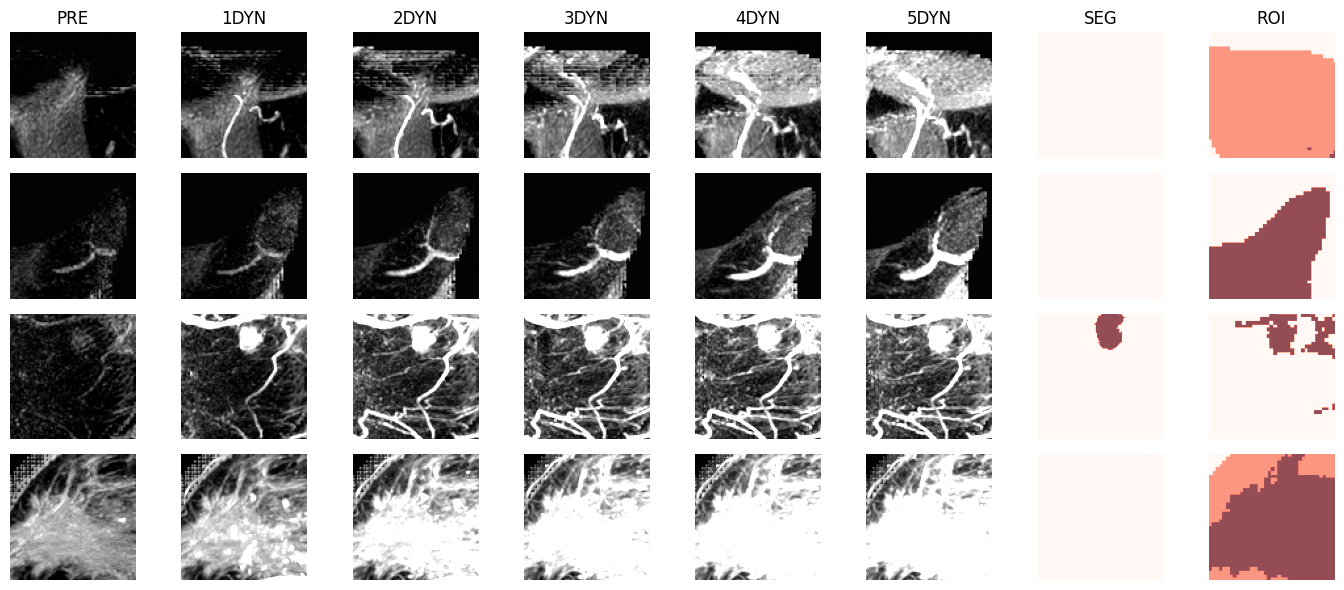

In [18]:
train_ds = Dataset(data=plist_tr, transform=tr_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

for check_data in train_loader:
    plt.figure(figsize=(14, 6))
    dyn_keys = ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn", "img_5dyn", "seg", "roi"]
    num_samples = min(4, check_data["img_pre"].shape[0])

    for i in range(num_samples):
        for j, key in enumerate(dyn_keys):
            img = check_data[key][i][0]
            plt.subplot(num_samples, len(dyn_keys), i * len(dyn_keys) + j + 1)
            if key in ["seg", "roi"]:
                plt.imshow(torch.amax(img, dim=2), cmap='Reds', alpha=0.7)
            else:
                plt.imshow(torch.amax(img, dim=2), cmap='gray', vmin=0, vmax=2)

            plt.axis('off')
            if i == 0:
                plt.title(key.replace("img_", "").upper())

    plt.tight_layout()
    plt.show()
    break


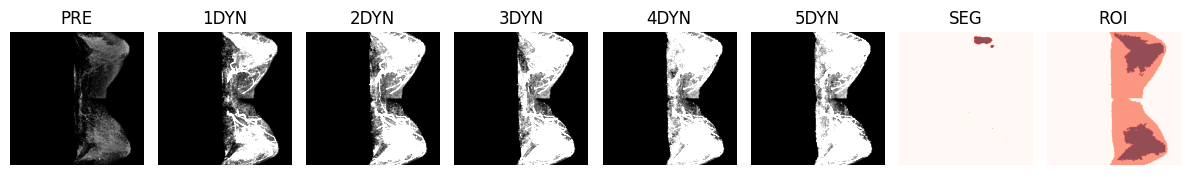

In [19]:
valid_ds = Dataset(data=plist_vd, transform=vd_transforms)
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False)

for check_data in valid_loader:
    plt.figure(figsize=(12, 6))
    dyn_keys = ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn", "img_5dyn", "seg", "roi"]

    for j, key in enumerate(dyn_keys):
        img = check_data[key][0][0]
        plt.subplot(1, len(dyn_keys), j + 1)

        if key in ["seg", "roi"]:
                plt.imshow(torch.amax(img, dim=2), cmap='Reds', alpha=0.7)
        else:
            plt.imshow(torch.amax(img, dim=2), cmap='gray', vmin=0, vmax=1)

        plt.axis('off')
        plt.title(key.replace("img_", "").upper())

    plt.tight_layout()
    plt.show()
    break

In [20]:
device = torch.device("cuda:1")

model = Baseline_IUnet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    features=(28, 32, 64, 128, 256, 28),
)

best_val_loss = 1000.0
max_epochs = 40
valid_bool = True
valid_interval = 4
lr = 1e-4
wd = 1e-3

optimizer = torch.optim.AdamW(model.parameters(), lr=lr,weight_decay=wd)
model.to(device);

BasicUNet features: (28, 32, 64, 128, 256, 28).


In [ ]:
for epoch in range(max_epochs):
    for train_idx, train_batch in enumerate(train_loader): # Training
        keys = ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn", "img_5dyn"]
        imgs = {k: torch.nan_to_num(train_batch[k], 0).to(device) for k in keys}
        img_pre, img_1dyn, img_2dyn, img_3dyn, img_4dyn, img_5dyn = (
            imgs["img_pre"], imgs["img_1dyn"], imgs["img_2dyn"],
            imgs["img_3dyn"], imgs["img_4dyn"], imgs["img_5dyn"]
        )
        
        msk = torch.pow(torch.abs(img_5dyn-img_1dyn),0.5)
        optimizer.zero_grad()
        model.train()
        
        dyn_imgs = [train_batch[k].to(device) for k in ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn"]]
        outputs = model(torch.cat(dyn_imgs, dim=1))
        output_2dyn, output_3dyn, output_4dyn, output_5dyn = outputs

        loss_dict = compute_total_loss(
            outputs=outputs,
            targets=(img_2dyn, img_3dyn, img_4dyn, img_5dyn),
            mask=msk,
            device=device,
        )

        loss_total = loss_dict["total"]
        loss_total.backward()
        optimizer.step()
        
    gc.collect()
    torch.cuda.empty_cache()        

    if valid_bool and epoch%valid_interval ==0 : # Validation
        roi_size = (96, 96, 48)
        sw_batch_size = 1

        model.eval()
        with torch.no_grad():
            for idx, valid_batch in enumerate(valid_loader):
                keys = ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn", "img_5dyn"]
                imgs = {k: torch.nan_to_num(valid_batch[k], 0).to(device) for k in keys}
                img_pre, img_1dyn, img_2dyn, img_3dyn, img_4dyn, img_5dyn = (
                    imgs["img_pre"], imgs["img_1dyn"], imgs["img_2dyn"],
                    imgs["img_3dyn"], imgs["img_4dyn"], imgs["img_5dyn"]
                )
                roi = torch.nan_to_num(valid_batch["roi"].to(device), 0)
                dyn_imgs = [valid_batch[k].to(device) for k in ["img_pre", "img_1dyn", "img_2dyn", "img_3dyn", "img_4dyn"]]

                outputs = sliding_window_inference(
                    torch.cat(dyn_imgs, dim=1),
                    roi_size, sw_batch_size, model,
                    overlap=0.5, mode="gaussian",
                )
                    
                output_2dyn, output_3dyn, output_4dyn, output_5dyn = outputs
                for out in outputs:
                    out[roi == 0] = 0
                        
                loss_dict = compute_total_loss(
                    outputs=outputs,
                    targets=(img_2dyn, img_3dyn, img_4dyn, img_5dyn),
                    mask=None,
                    device=device,
                )
        gc.collect()
        torch.cuda.empty_cache()    